In [14]:
# Imports and functions
import time
import copy
import math
from math import ceil
from matplotlib.colors import ListedColormap
from scipy.optimize import minimize, basinhopping
from joblib import Parallel, delayed
import multiprocessing
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.integrate import solve_ivp
import numpy as np
from scipy import stats
from scipy.stats import norm
import warnings
from datetime import datetime
import os
from typing import List, Dict, Any
from scipy.stats import norm, uniform
import win32com.client as win32

df_Rahil = pd.read_excel("../Data/References/Rahil_2020/Table8_Healed.xlsx", usecols=list(range(0, 143)))
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] <= 8]
df_Murine = pd.read_excel("../Data/Murine Data.xlsx")


In [5]:
# Infrastructure functions
class TimeManager:
    def __init__(self):
        self.start_time = time.time()

    def check_timeout(self, timeout: int) -> bool:
        return (time.time() - self.start_time) > timeout

    def reset_start_time(self):
        self.start_time = time.time()

    def get_elapsed_time(self) -> float:
        return time.time() - self.start_time

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, dist='uniform', method='fixed', space='log10', dtype=np.float32):
        self.name = name
        self.dtype = dtype
        self.space = space
        self.l_lim = l_lim
        self.u_lim = u_lim
        self.dist = self._create_distribution(dist, l_lim, u_lim)
        self.val = self._convert_to_type(val if val is not None else self.sample_prior())
        self.method = method

    def _transform_bound(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _inverse_transform(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value
        else:
            raise ValueError(f"Unsupported space type: {self.space}")

    def _create_distribution(self, dist, l_lim, u_lim):
        if dist == 'uniform':
            return uniform(loc=l_lim, scale=u_lim - l_lim)
        elif dist == 'normal':
            return norm(loc=(l_lim + u_lim) / 2, scale=(u_lim - l_lim) / 6)  # Assuming 99.7% data within bounds
        else:
            raise ValueError(f"Unsupported distribution type: {dist}")

    def _convert_to_type(self, value):
        return np.array(value, dtype=self.dtype).item()

    def sample_prior(self):
        sampled_value = self.dist.rvs()
        return self._convert_to_type(self._inverse_transform(sampled_value))

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        if self.space == 'log10':
            l_lim_transformed = np.log10(self.l_lim)
            u_lim_transformed = np.log10(self.u_lim)
            values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
            values = 10 ** values
        elif self.space == 'normal':
            values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        else:
            raise ValueError(f"Unsupported space type: {self.space}")
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value
            self.reset_solutions()

    def __getstate__(self):
        # Return the state to be pickled
        return self._parameters

    def __setstate__(self, state):
        # Restore state from the unpickled state
        self._parameters = state

    def get_sampled_parameters(self):
        return {name: param for name, param in self._parameters.items() if param.method == 'sample'}

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def sample_priors(self, force_sample=False):
        for name, param in self._parameters.items():
            if force_sample or param.method == 'sample':
                param.val = param.sample_prior()
        return {name: param for name, param in self._parameters.items()}

    def reset_solutions(self):
        # Reset solutions in all patients whenever a parameter value is updated
        if hasattr(self, 'patients'):
            for patient in self.patients.values():
                patient.sol = None
                patient.sse = None

    def compute_mean_parameters(self):
        for param_name, param_obj in self._parameters.items():
            values = [p.parameters._parameters[param_name].val for p in self.patients.values()]
            mean_val = np.mean(values)
            self._parameters[param_name].val = mean_val

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, dtype: np.dtype = np.float32, force_positive: bool = True, scale: float = 1.0):
        self.label = label
        self.initial_value = dtype(initial_value)
        self.dtype = dtype
        self.force_positive = force_positive
        self.time_points = np.array([0.0], dtype=dtype)
        self.values = np.array([self.initial_value], dtype=dtype)
        self.sse = sse

    def update_value(self, t: float, new_value: float):
        new_value = np.clip(new_value, np.finfo(self.dtype).min, np.finfo(self.dtype).max)
        new_value = self.dtype(new_value)
        if self.force_positive:
            new_value = max(new_value, 0)
        self.time_points = np.append(self.time_points, self.dtype(t))
        self.values = np.append(self.values, new_value)

    def get_latest_value(self) -> float:
        return self.values[-1]

    def get_value_at(self, t_delay: float) -> float:
        value = np.interp(self.dtype(t_delay), self.time_points, self.values, left=self.initial_value, right=self.values[-1])
        if self.force_positive:
            value = max(value, 0)
        return value

    def reset(self):
        self.time_points = np.array([0.0], dtype=self.dtype)
        self.values = np.array([self.initial_value], dtype=self.dtype)

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, dtype={self.dtype}, force_positive={self.force_positive})"

class States:
    def __init__(self, states_config: list, dtype: np.dtype = np.float32, force_positive: bool = True):
        self.dtype = dtype
        self.force_positive = force_positive
        self.states = {config['label']: State(**config, dtype=dtype, force_positive=force_positive) for config in states_config}
        self.tau = {}
        self.state_labels = [state.label for state in self.states.values()]

    def get_delayed_state(self, state_label: str) -> float:
        return self.tau.get(state_label, 0.0)

    def get_current_values_as_array(self) -> np.ndarray:
        return np.array([self.states[label].get_latest_value() for label in self.state_labels], dtype=self.dtype)

    def __getattr__(self, name: str) -> float:
        if name in self.states:
            return self.states[name].get_latest_value()
        elif name in self.tau:
            return self.tau[name]
        else:
            raise AttributeError(f"'States' object has no attribute '{name}'")

    def update_states(self, t: float, new_values: list):
        for label, value in zip(self.state_labels, new_values):
            self.states[label].update_value(t, value)

    def calculate_delayed_states(self, t: float, delays: list, p: any):
        for delay_info in delays:
            tau, dependent_state, affecting_state = delay_info['tau'], delay_info['dependent_state'], delay_info['affecting_state']
            delay_time = getattr(p, tau).val
            delayed_value = self.states[affecting_state].get_value_at(t - delay_time)
            delayed_state_label = f"{affecting_state}_{dependent_state}"
            self.tau[delayed_state_label] = delayed_value

    def reset_delayed_states(self):
        self.tau.clear()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, dtype={self.dtype}, force_positive={self.force_positive})"

class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, model, df_params=None, sol=None, solve_time=None, sse=None):
        self.id = id
        self.color = color
        self.t_span = t_span
        self.df = df[df['VOLUNTEER'] == id].copy() if id not in ['MP'] else df
        self.parameters = parameters
        self.states = states
        self.model = model
        self.sol = sol
        self.solve_time = solve_time
        self.sse = sse

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)

    def solve(self):
        try:
            self.sol, self.solve_time = SmartSolve((
                self.model, self.parameters, self.states, self.t_span))
        except Exception as e:
            self.sol = None
            self.solve_time = None
            print(f"Error solving patient {self.id}: {e}")   

    def compare(self, use_mean=False, use_log_loss=False):
        sse = 0
        mean_sse = 0
        if self.sol is None:
            print('No ODE solution, inf error')
            self.sse = np.inf
        else:
            for idx, state in enumerate(self.states):
                state_label = state['label']
                if state.get('sse', True):
                    if state_label in self.df.columns:
                        # Get the data points and their time points
                        #print(f'{state_label} data:')
                        data_values = self.df[state_label].values * state.get('scale', 1.0)
                        time_points = self.df['DAY'].values
                        valid_indices = ~np.isnan(data_values)
                        data_values = data_values[valid_indices]
                        time_points = time_points[valid_indices]
                        #print(data_values)
                        #print('time points')
                        #print(time_points)
                        if len(data_values) > 0: # Ensure there are valid data points
                            # Interpolate the model values at these time points
                            model_time_points = self.sol.t
                            model_values = self.sol.y[idx]
                            interpolated_model_values = np.interp(time_points, model_time_points, model_values)
                            #print('interpolated model points:')
                            #print(interpolated_model_values)
                            for t_point in np.unique(time_points):
                                data_at_t = data_values[time_points == t_point]
                                model_at_t = interpolated_model_values[time_points == t_point][0]
                                #print(f'At {t_point}, data={data_at_t}, model={model_at_t}')
                                data_mean = np.mean(data_at_t)
                                #print(f'Data mean {data_mean}')
                                log_data_mean = np.log10(np.maximum(data_mean,1))
                                #print(f'Log Data mean {log_data_mean}')
                                logdata = np.log10(np.maximum(data_at_t, 1))
                                #print(f'Data log {logdata}')
                                logmodel = np.log10(np.maximum(model_at_t, 1))
                                #print(f'Model log {logmodel}')
                                error = np.sum((logdata - logmodel)** 2)
                                #print(f'error {error}')
                                mean_error = (log_data_mean - logmodel)** 2
                                #print(f'mean error {mean_error}')
                                sse += error
                                mean_sse += mean_error
                                #print(f'Current sse: {sse}') 
                                #print(f'Current mean sse: {mean_sse}')  
                    else:
                        print(f"State {state_label} not found in dataframe columns during SSE calculation.")
         
        if use_mean:
            current_sse = mean_sse
        else:
            current_sse = sse               
        if use_log_loss:
            if sse != 0:
                self.sse = np.log2(current_sse)
            else:
                self.sse = current_sse
        else:
            self.sse = current_sse

            return self.sse

    def optimize_parameters(self):
        try:
            fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method == 'fit'}
        except AttributeError:
            print("No fit parameters found")
            return

        if not fit_parameters:
            print("No parameters to optimize")
            return

        # Get initial values, bounds, and parameter names
        initial_values = [param.val for param in fit_parameters.values()]
        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        param_names = list(fit_parameters.keys())

        def objective_function(x):
            for i, name in enumerate(param_names): # Update parameter values
                self.parameters._parameters[name].val = x[i]
            self.solve()
            self.compare(self)
            return self.sse

        result = basinhopping(
            objective_function, 
            x0=initial_values, 
            minimizer_kwargs={
                'method': 'L-BFGS-B', 
                'bounds': bounds, 
                'args': (), 
                'jac': None, 
                'tol': None, 
                'options': None, 
                'callback': None
            }, 
            niter=2, 
            T=1.0, 
            stepsize=0.5, 
            interval=5, 
            disp=True, 
            niter_success=5, 
            seed=None, 
            take_step=None, 
            accept_test=None, 
            callback=None
        )

        # Update parameter values with the optimized results
        for i, name in enumerate(param_names):
            self.parameters._parameters[name].val = result.x[i]
            print(f"Parameter {name} updated to {result.x[i]} for patient {self.id}")

        # Solve the ODE system with the final optimized parameters
        self.solve()
        self.compare()

    def __repr__(self):
        sol_repr = 'None'
        if self.sol is not None:
            if self.sol.status == 0:
                sol_repr = f"shape={self.sol.y.shape}"
            else:
                sol_repr = f"status={self.sol.status}, message={self.sol.message}"

        sse_repr = self.sse if self.sse is not None else 'None'

        return f"Patient({self.id}, sol={np.shape(self.sol)}, sse={sse_repr}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, model, parameter_file=None):
        # Prepend the Mean Patient (MP) ID
        ids.insert(0, 'MP')
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df[df['VOLUNTEER'].isin(ids)].copy()
        self.parameters = parameters
        self.states = states
        self.model = model

        # Load the parameters from the Excel file once
        self.df_params = self.load_excel_parameters(parameter_file) if parameter_file else None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df if id not in ['MP'] else df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.model,
                self.df_params
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        excel = None
        workbook = None
        new_instance = False
        already_open = False

        try:
            # Check if Excel is already running
            try:
                excel = win32.GetActiveObject("Excel.Application")
            except Exception:
                # If Excel is not running, start a new instance
                excel = win32.Dispatch("Excel.Application")
                new_instance = True
            
            # Check if the workbook is already open
            for wb in excel.Workbooks:
                if os.path.abspath(wb.FullName) == parameter_file:
                    workbook = wb
                    already_open = True
                    break

            # If the workbook is not already open, open it
            if not workbook:
                workbook = excel.Workbooks.Open(parameter_file)
            
            # Select the first sheet (or you can specify the sheet name/index if needed)
            sheet = workbook.Sheets(1)
            
            # Get the used range of the sheet
            used_range = sheet.UsedRange
            # Extract values from the used range
            data = used_range.Value

            # Convert to a pandas DataFrame
            df_params = pd.DataFrame(data[1:], columns=data[0])
            
        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            # If the workbook was opened by this method, close it after reading
            if workbook and not already_open:
                workbook.Close(SaveChanges=False)
            # Quit the Excel application if it was a new instance created by this method
            if new_instance:
                excel.Quit()
            elif not already_open:
                # Make sure the workbook is still visible if it was already open
                excel.Visible = True
            
        return df_params

    def solve(self, mode='all'):
        if mode == 'all':
            for patient in self.patients.values():
                patient.solve()
        elif mode == 'mp':
            self.patients['MP'].solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()

    def optimize_parameters(self, mode='all'):
        if mode == 'all':
            for patient in self.patients.values():
                patient.optimize_parameters()
        elif mode == 'mp':
            self.patients['MP'].optimize_parameters()

    def sweep_parameter(self, param_name, num_points=100):
        # Find the parameter to sweep
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        # Generate sweep values
        sweep_values = param_to_sweep.sweep(num_points)
        sweep_ids = [f'S{i}' for i in range(num_points)]
        num_cores = multiprocessing.cpu_count() - 1
    
        def solve_for_value(i, value):
            # Set the parameter value to the current sweep value
            self.parameters._parameters[param_name].val = value
            # Create a new patient instance with the updated parameter value
            patient = Patient(
                id=sweep_ids[i],
                color=sns.color_palette("viridis", num_points)[i],
                t_span=self.t_span,
                df=self.df,
                parameters=copy.deepcopy(self.parameters),
                states=copy.deepcopy(self.states),
                model=self.model
            )
            # Solve the model for the current patient
            patient.solve()
            return copy.deepcopy(patient.sol.y)
    
        # Parallelize the solving process across available CPU cores
        results = Parallel(n_jobs=num_cores)(delayed(solve_for_value)(i, value) for i, value in enumerate(sweep_values))
        
        return sweep_values, results

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

def SmartSolve(task, overflow=1E14, mode='normal'):
    def inner_solve(funx, param_set, states_config, t_span, mode):
        states_config_copy = states_config.copy()
        stages = np.int8(param_set.lct_stages.val)
        for i in range(stages):
            states_config_copy.append({'label': f'Z{i}', 'initial_value': 0.0})
        states_instance = States(states_config_copy)
        if mode=='normal':
            y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config_copy])
        elif mode=='log':
            # Take the log10 of the initial states, except for 0's which are set to a small number (1E-2)
            y0 = np.array([np.log10(states_instance.states[config['label']].initial_value) if states_instance.states[config['label']].initial_value != 0 else 1E-2 for config in states_config_copy])
        time_manager = TimeManager()
        
        # Set the number of initial target cells (T0) from the parameter
        y0[0] = param_set.T0.val
        
        def overflow_event(t, y):
            return overflow - max(abs(yi) for yi in y)  

        if np.shape(t_span)[0] > 2:
            t_eval = t_span[1:-1]
            t_span = [t_span[0], t_span[-1]]
        else:
            t_eval = None

        overflow_event.terminal = True
        overflow_event.direction = -1
        warnings.filterwarnings("ignore", message="The following arguments have no effect for a chosen solver:*")
        
        methods = [('RK45',1.5),('BDF',10.0)]
        for method, timeout in methods:
            try:
                sol = solve_ivp(
                    fun=lambda t, y: funx(t, y, param_set, states_instance, time_manager, timeout=timeout),
                    t_span=t_span, y0=y0, method=method, t_eval=t_eval, dense_output=False,
                    events=overflow_event, vectorized=False, rtol=1e-4, atol=1e-5, jac=None,
                    jac_sparsity=None, max_step=0.1, min_step=1e-5, first_step=None
                )

                if sol.success:
                    elapsed_time = time_manager.get_elapsed_time()
                    # Add the background E0
                    if mode=='normal':
                        sol.y[4] += param_set.E0.val
                    elif mode=='log':
                        sol.y[4] = np.log10(10**sol.y[4] + param_set.E0.val)
                        # Exponentiate all states to return the sol to natural space
                        sol.y = 10**sol.y
                    else:
                        raise ValueError("Invalid mode. Must be 'normal' or 'log'.")
                    return sol, elapsed_time
                else:
                    if sol.status == -1:
                        print(f"Integration step failed. Method: {method}")
                    elif sol.t_events and sol.t_events[0].size > 0:
                        print(f"Overflow event triggered. Method: {method}")
                    else:
                        print(f"Unknown failure mode. Status: {sol.status}, Method: {method}")

                    if method != methods[-1][0]:
                        continue
                    else:
                        raise Exception("All methods failed.")
            except TimeoutError:
                if method != methods[-1][0]:
                    continue
                else:
                    raise TimeoutError("Timeout occurred for all methods.")

    #try:
    sol, integration_time = inner_solve(*task, mode=mode)
    return sol, integration_time
    #except Exception as e:
        #print(f"Exception occurred in SmartSolve: {e}")
        #return None, None

Patient MP SSE: None


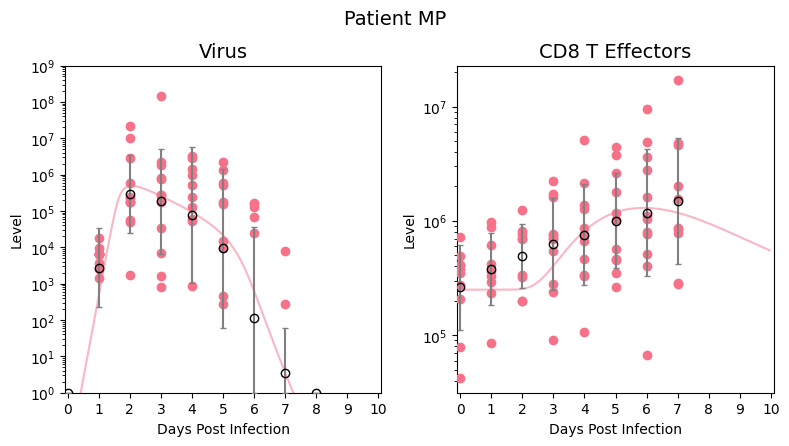

In [50]:
ids = [103, 107, 110, 111, 112, 204, 207, 301, 302, 308, 311, 312]
#ids = [111, 204, 207, 302, 308, 312] # Best 6 T cell patients
#ids = [312]
df = df_Rahil[df_Rahil['VOLUNTEER'].isin(ids)]
t_span = [0.0, 10]
parameters = Parameters(
    E0=Parameter(name='E0', val=2.5E5, l_lim=1E4, u_lim=1E6, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E8, l_lim=1E4, u_lim=1E10, method='fixed', space='log10'),
    beta=Parameter(name='beta', val=8E-5, l_lim=1E-5, u_lim=1E-3, method='fit', space='log10'),
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'),
    p=Parameter(name='p', val=0.04, l_lim=0.01, u_lim=0.1, method='fit', space='log10'),
    c=Parameter(name='c', val=20, l_lim=10, u_lim=50, method='fit', space='log10'),
    delta=Parameter(name='delta', val=0.96, l_lim=0.75, u_lim=2.0, method='fixed', space='log10'), #0.962710827
    delta_E=Parameter(name='delta_E', val=17, l_lim=1, u_lim=100, method='fixed', space='log10'),
    Kd=Parameter(name='Kd', val=4E6, l_lim=1E5, u_lim=1E7, method='fixed', space='log10'),
    xi=Parameter(name='xi', val=0.015, l_lim=0.01, u_lim=0.05, method='fixed', space='log10'),
    d_E=Parameter(name='d_E', val=0.8, l_lim=0.5, u_lim=1.0, method='fixed', space='log10'),
    a=Parameter(name='a', val=0.747, l_lim=0.5, u_lim=1.0, method='fixed', space='log10'),
    tau=Parameter(name='tau', val=1.0, l_lim=0.75, u_lim=1.25, method='fixed', space='log10'),
    lct_stages=Parameter(name='lct_stages', val=3, l_lim=2, u_lim=10, method='fixed', space='log10', dtype=np.int8),
    tau_T=Parameter(name='tau_T', val=1.4, l_lim=0.1, u_lim=3.0, method='fixed', space='log10')
)
states = [
    {'label': 'T', 'initial_value': 4E8, 'sse': False,},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False,},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False,},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'E', 'initial_value': 0.0, 'sse': False, 'scale': 5.6E7},
    #{'label': 'Ef', 'initial_value': 0.0, 'sse': False, 'scale': 5.6E7},
    #{'label': 'EM', 'initial_value': 0.0},
]
def LCTModel(t: float, y: np.ndarray, p: Parameters, s: States, time_manager: TimeManager, timeout: int = None) -> np.ndarray:
    if timeout is not None and time_manager.check_timeout(timeout):
        raise TimeoutError('ODE Solver timeout.')
    
    stages = np.int8(p.lct_stages.val)
    y = y.flatten()
    y[:] = y.clip(min=0.0)
    num_states = len(s.states) - stages
    z = y[num_states:].flatten()
    for label, value in zip(s.state_labels, y):
        s.states[label].update_value(t, value)
        
    # Calculate delayed states 
    #s.calculate_delayed_states(t, [('tau_T', 'Ef', 'E')], p)
    #E_tauT = s.get_delayed_state('E_Ef')

    dT_dt = -p.beta.val * s.T * s.V
    dI1_dt = p.beta.val * s.T * s.V - p.k.val * s.I1
    dI2_dt = p.k.val * s.I1 - (p.delta.val * s.I2) - ((p.delta_E.val * s.E * s.I2) / (p.Kd.val + s.I2))
    #dI2_dt = max(dI2_dt, -s.I2)
    dV_dt = p.p.val * s.I2 - p.c.val * s.V

    dz_dt = np.zeros(stages)
    dz_dt[0] = (1/p.tau.val) * (p.a.val * s.I2 - z[0])
    for i in range(1, stages):
        dz_dt[i] = (1/p.tau.val) * (z[i-1] - z[i])
    dE_dt = p.xi.val / p.tau.val * z[-1] - p.d_E.val * s.E
    #dEf_dt = E_tauT
    
    return np.concatenate(([dT_dt, dI1_dt, dI2_dt, dV_dt, dE_dt], dz_dt))
def LCTModelLog(t: float, log_y: np.ndarray, p: Parameters, s: States, time_manager: TimeManager, timeout: int = None) -> np.ndarray:
    if timeout is not None and time_manager.check_timeout(timeout):
        raise TimeoutError('ODE Solver timeout.')
    
    stages = np.int8(p.lct_stages.val)
    log_y = log_y.flatten()
    log_y[:] = log_y.clip(min=-2.0)  # To avoid log10 of values close to zero

    # Convert log10 values back to natural space for calculations
    y = 10 ** np.clip(log_y, np.log10(1E-2), np.log10(1E12))
    num_states = len(s.states) - stages
    z = y[num_states:].flatten()
    
    for label, log_value in zip(s.state_labels, log_y):
        s.states[label].update_value(t, 10 ** np.clip(log_value, np.log10(1E-2), np.log10(1E12)))  # Update state values in natural space with clipping

    dT_dt = -p.beta.val * y[0] * y[3]
    dI1_dt = p.beta.val * y[0] * y[3] - p.k.val * y[1]
    I_plus  = p.k.val * y[1]
    I_neg1 = - p.delta.val * y[2]
    I_neg2 = - (p.delta_E.val * y[4] * y[2]) / (p.Kd.val + y[2])
    print(f'Time:{t}')
    print(f'I+:{I_plus}')
    print(f'I-1:{I_neg1}')
    print(f'I-2:{I_neg2}')
    dI2_dt = I_plus + I_neg1 + I_neg2 
    dV_dt = p.p.val * y[2] - p.c.val * y[3]

    dz_dt = np.zeros(stages)
    dz_dt[0] = (1 / p.tau.val) * (p.a.val * y[2] - z[0])
    for i in range(1, stages):
        dz_dt[i] = (1 / p.tau.val) * (z[i-1] - z[i])
    dE_dt = p.xi.val / p.tau.val * z[-1] - p.d_E.val * y[4]
    
    # Convert the derivatives back to log10 space
    dT_dt_log = dT_dt / (y[0] * np.log(10))
    dI1_dt_log = dI1_dt / (y[1] * np.log(10))
    dI2_dt_log = dI2_dt / (y[2] * np.log(10))
    dV_dt_log = dV_dt / (y[3] * np.log(10))
    dE_dt_log = dE_dt / (y[4] * np.log(10))
    
    dz_dt_log = dz_dt / (z * np.log(10))
    
    # Return the combined log derivatives
    return np.concatenate(([dT_dt_log, dI1_dt_log, dI2_dt_log, dV_dt_log, dE_dt_log], dz_dt_log))
patients = Patients(ids=ids, df=df, t_span=t_span, parameters=parameters, states=states, model=LCTModel)
patients.solve(mode='all')
#patients.compare()
#patients.optimize_parameters(mode='mp')
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', '2nd_data_key': 'V', 'sol_key': 3, 'data_scale': None, 'ylims': [1,1E9]},
    {'title': 'CD8 T Effectors', 'data_key': 'E_Scaled', '2nd_data_key': None, 'sol_key': 4, 'data_scale': None, 'ylims': None}, #[3E4,3E7]
    #{'title': 'Lung T Effectors', 'data_key': None, 'sol_key': 5, 'data_scale': None, 'ylims': None},
    #{'title': 'LCT Bin 0', 'data_key': None, 'sol_key': 5, 'data_scale': None, 'ylims': None},
    #{'title': 'LCT Bin 1', 'data_key': None, 'sol_key': 6, 'data_scale': None, 'ylims': None},
    #{'title': 'LCT Bin 2', 'data_key': None, 'sol_key': 7, 'data_scale': None, 'ylims': None},
    #{'title': 'LCT Bin 3', 'data_key': None, 'sol_key': 8, 'data_scale': None, 'ylims': None},
    #{'title': 'IL-6', 'data_key': 'IL-6', '2nd_data_key': 'IL6', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'IL-8', 'data_key': 'IL-8', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'IL-10', 'data_key': 'IL-10', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'TNFa', 'data_key': 'TNFa',  '2nd_data_key': 'TNFA', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'IFNy', 'data_key': 'IFNy',  '2nd_data_key': 'G', 'sol_key': None, 'data_scale': None, 'ylims': [10, 200]},
    #{'title': 'IFNa2', 'data_key': 'IFNa2', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'G-CSF', 'data_key': 'G-CSF', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'GM-CSF', 'data_key': 'GM-CSF',  '2nd_data_key': 'GMCSF', 'sol_key': None, 'data_scale': None, 'ylims': [7, 200]},
    #{'title': 'MCP-1', 'data_key': 'MCP-1',  '2nd_data_key': 'MCP1', 'sol_key': None, 'data_scale': None, 'ylims': [1000, 30000]},
]
def calculate_mean_patient_data(patients, data_key):
    all_data = []
    for patient in patients.values():
        df = patient.df[['DAY', data_key]].copy()
        df.loc[df[data_key] < 1, data_key] = 1
        all_data.append(df)

    combined_data = pd.concat(all_data)
    mean_data = combined_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).mean()).reset_index()
    std_data = combined_data.groupby('DAY')[data_key].apply(lambda x: np.log10(x).std()).reset_index()

    return mean_data, std_data
def calculate_mean_twin_data(twin_data, data_key):
    twin_data = twin_data[['TIME', data_key]].copy()
    twin_data.loc[twin_data[data_key] < 1, data_key] = 1

    mean_data = twin_data.groupby('TIME')[data_key].apply(lambda x: np.log10(x).mean()).reset_index()
    std_data = twin_data.groupby('TIME')[data_key].apply(lambda x: np.log10(x).std()).reset_index()

    return mean_data, std_data
def plot(patients, subplot_config, twin_data=None):  
    t_span = patients.t_span
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))
    base_font_size = 12
    
    all_mean_data = {}
    all_std_data = {}
    all_mean_twin_data = {}
    all_std_twin_data = {}

    for config in subplot_config:
        if config['data_key']:
            mean_data, std_data = calculate_mean_patient_data(patients.patients, config['data_key'])
            all_mean_data[config['data_key']] = mean_data
            all_std_data[config['data_key']] = std_data
        if config['2nd_data_key'] and twin_data is not None:
            mean_twin_data, std_twin_data = calculate_mean_twin_data(twin_data, config['2nd_data_key'])
            all_mean_twin_data[config['2nd_data_key']] = mean_twin_data
            all_std_twin_data[config['2nd_data_key']] = std_twin_data

    for patient_id, patient in patients.patients.items():
        if patient_id == 'MP': # TODO Mode switch for MP vs. All vs. Single
        #if patient_id != 'MP':
            print(f"Patient {patient_id} SSE: {patient.sse}")

            fig, axs = plt.subplots(n_rows, n_cols, figsize=(8, 8), squeeze=True)
            fig.suptitle(f"Patient {patient_id}", fontsize=base_font_size + 2)
            axs = axs.flatten()

            for i, config in enumerate(subplot_config):
                ax = axs[i]
                ax.set_title(config['title'], fontsize=base_font_size + 2)

                if config['data_key']:
                    volunteer_data = patient.df.copy()
                    if config['data_scale'] is not None:
                        volunteer_data[config['data_key']] *= config['data_scale']
                        
                    ax.scatter(volunteer_data['DAY'], volunteer_data[config['data_key']], color=patient.color, alpha=1.0, zorder=5)

                    # Plot Mean Patient data
                    mean_data = all_mean_data[config['data_key']]
                    std_data = all_std_data[config['data_key']]
                    
                    # Split std into positive and negative parts
                    std_positive = std_data.copy()
                    std_negative = std_data.copy()
                    
                    # Ensure mean minus std is floored at 1
                    mean_values = 10 ** mean_data[config['data_key']]
                    std_positive_values = 10 ** (mean_data[config['data_key']] + std_positive[config['data_key']]) - mean_values
                    std_negative_values = mean_values - 10 ** np.maximum(mean_data[config['data_key']] - std_negative[config['data_key']], 0)
                    
                    ax.errorbar(mean_data['DAY'], mean_values, 
                                yerr=[std_negative_values, std_positive_values], fmt='o', markerfacecolor='none', color='black', ecolor='gray', capsize=2, zorder=10)
                if config['sol_key'] is not None:
                    sol_t = patient.sol.t
                    sol_y_raw = patient.sol.y[config['sol_key']]
                    sol_y = np.where(sol_y_raw > 1E12, 1E12, np.where(sol_y_raw < 0, 1E-2, sol_y_raw))
                    ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)
                if config['ylims']:
                    ax.set_ylim(config['ylims'])
                ax.set_yscale('log')
                y_low, y_high = ax.get_ylim()
                if y_low < 1:
                    ax.set_ylim(bottom=1)
                ax.set_xticks(x_ticks)
                ax.set_xlim([-0.1, 10.1])
                
                ax.margins(x=0.05)
                ax.set_xlabel('Days Post Infection')
                ax.set_ylabel('Level')

                if config['2nd_data_key'] and twin_data is not None:
                    twin_ax = ax.twinx()
                    twin_mean_data = all_mean_twin_data[config['2nd_data_key']]
                    twin_std_data = all_std_twin_data[config['2nd_data_key']]
                    
                    twin_mean_values = 10 ** twin_mean_data[config['2nd_data_key']]
                    twin_std_positive_values = 10 ** (twin_mean_data[config['2nd_data_key']] + twin_std_data[config['2nd_data_key']]) - twin_mean_values
                    twin_std_negative_values = twin_mean_values - 10 ** np.maximum(twin_mean_data[config['2nd_data_key']] - twin_std_data[config['2nd_data_key']], 0)
                    
                    twin_ax.errorbar(twin_mean_data['TIME'], twin_mean_values, 
                                yerr=[twin_std_negative_values, twin_std_positive_values], fmt='o', markerfacecolor='none', color='blue', ecolor='blue', capsize=2, zorder=10)

            for j in range(i + 1, len(axs)):
                axs[j].set_visible(False)
            plt.tight_layout()
            plt.show()
plot(patients, subplot_configuration)

Patient MP SSE: None


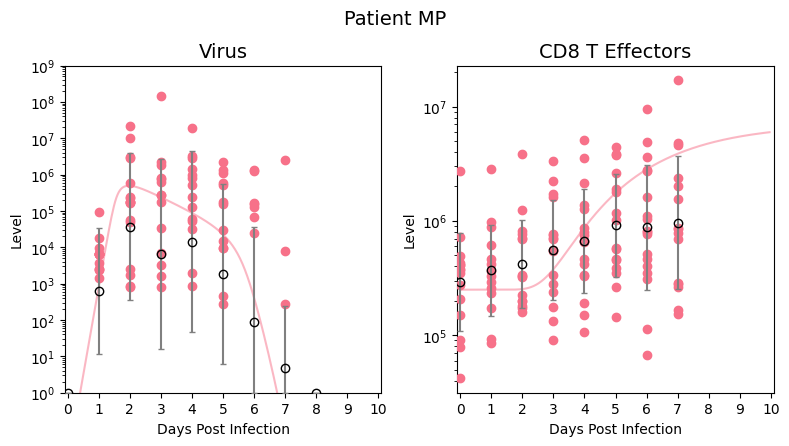

In [ ]:
# Monolix Population Fit Parameters
ids = [101, 103, 107, 108, 109, 110, 111, 112, 201, 204, 207, 209, 301, 302, 304, 307, 308, 311, 312]
df = df_Rahil[df_Rahil['VOLUNTEER'].isin(ids)]
parameters = Parameters(
    E0=Parameter(name='E0', val=2.5E5, l_lim=1E4, u_lim=1E6, method='fixed', space='log10'),
    beta=Parameter(name='beta', val=0.00009, l_lim=1E-5, u_lim=1E-4, method='fixed', space='normal'),
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'),
    p=Parameter(name='p', val=0.04, l_lim=0.01, u_lim=0.1, method='fixed', space='normal'),
    c=Parameter(name='c', val=20, l_lim=1, u_lim=50, method='fixed', space='normal'),
    delta=Parameter(name='delta', val=0.96, l_lim=0.75, u_lim=2.0, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=10, l_lim=1, u_lim=100, method='fixed', space='log10'),
    Kd=Parameter(name='Kd', val=4E6, l_lim=1E4, u_lim=1E5, method='fixed', space='log10'),
    xi=Parameter(name='xi', val=0.031, l_lim=0.001, u_lim=0.1, method='fixed', space='log10'),
    d_E=Parameter(name='d_E', val=0.001, l_lim=0.1, u_lim=1.0, method='fixed', space='normal'),
    a=Parameter(name='a', val=0.87, l_lim=0.1, u_lim=1.0, method='fixed', space='log10'),
    tau=Parameter(name='tau', val=1.57, l_lim=0.1, u_lim=3.0, method='fixed', space='log10'),
    lct_stages=Parameter(name='lct_stages', val=3, l_lim=2, u_lim=10, method='fixed', space='normal', dtype=np.int8),
)
patients = Patients(ids=ids, df=df, t_span=t_span, parameters=parameters, states=states, model=LCTModel)
patients.solve(mode='mp')
#patients.compare()

subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3, 'data_scale': None, 'ylims': [1,1E9]},
    {'title': 'CD8 T Effectors', 'data_key': 'E_Scaled', 'sol_key': 4, 'data_scale': None, 'ylims': None}, #[3E4,3E7]
]
plot(patients, subplot_configuration)

Sweeping parameter: T0
Patient MP SSE: None
Patient 103 SSE: None
Patient 107 SSE: None
Patient 110 SSE: None
Patient 111 SSE: None
Patient 112 SSE: None
Patient 204 SSE: None
Patient 207 SSE: None
Patient 301 SSE: None
Patient 302 SSE: None
Patient 308 SSE: None
Patient 311 SSE: None
Patient 312 SSE: None


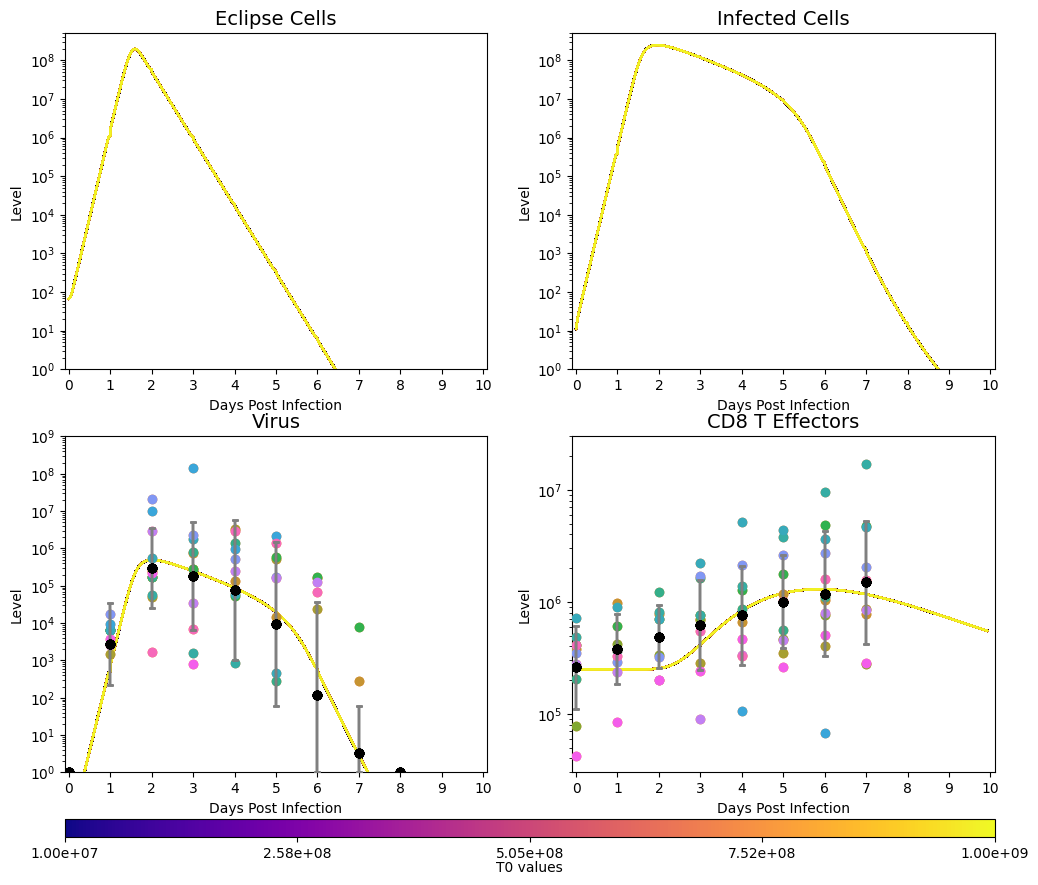

In [51]:
def sweep_plot(patients, subplot_config, sweep_param_name=None, sweep_values=None, sweep_results=None):
    t_span = patients.t_span
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))
    base_font_size = 12
    all_mean_data = {}
    all_std_data = {}

    for config in subplot_config:
        if config['data_key']:
            mean_data, std_data = calculate_mean_patient_data(patients.patients, config['data_key'])
            all_mean_data[config['data_key']] = mean_data
            all_std_data[config['data_key']] = std_data

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 12), squeeze=True)
    axs = axs.flatten()

    if sweep_values is not None and sweep_results is not None:
        cmap = plt.colormaps.get_cmap('plasma')
        colors = cmap(np.linspace(0, 1, len(sweep_values)))
        min_sweep = min(sweep_values)
        max_sweep = max(sweep_values)
        internal_ticks = np.linspace(min_sweep, max_sweep, num=5)
        tick_labels = [f"{val:.2e}" for val in internal_ticks]
        norm = plt.Normalize(vmin=min_sweep, vmax=max_sweep)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

    for patient_id, patient in patients.patients.items():
        print(f"Patient {patient_id} SSE: {patient.sse}")

        for i, config in enumerate(subplot_config):
            ax = axs[i]
            ax.set_title(config['title'], fontsize=base_font_size + 2)

            if config['data_key']:
                volunteer_data = patient.df.copy()
                if config['data_scale'] is not None:
                    volunteer_data[config['data_key']] *= config['data_scale']

                ax.scatter(volunteer_data['DAY'], volunteer_data[config['data_key']], color=patient.color, alpha=1.0, zorder=5)

                mean_data = all_mean_data[config['data_key']]
                std_data = all_std_data[config['data_key']]

                std_positive = std_data.copy()
                std_negative = std_data.copy()

                mean_values = 10 ** mean_data[config['data_key']]
                std_positive_values = 10 ** (mean_data[config['data_key']] + std_positive[config['data_key']]) - mean_values
                std_negative_values = mean_values - 10 ** np.maximum(mean_data[config['data_key']] - std_negative[config['data_key']], 0)

                ax.errorbar(mean_data['DAY'], mean_values,
                            yerr=[std_negative_values, std_positive_values], fmt='o', color='black', ecolor='gray', capsize=2, zorder=10)

            if config['sol_key'] is not None:
                if sweep_values is not None and sweep_results is not None:
                    for j, sweep_result in enumerate(sweep_results):
                        sol_y = sweep_result[config['sol_key']]
                        color = colors[j]
                        ax.plot(t_span[:len(sol_y)], sol_y, color=color, alpha=0.5)
                else:
                    sol_t = patient.sol.t
                    sol_y = patient.sol.y[config['sol_key']]
                    ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])
            ax.set_yscale('log')
            y_low, y_high = ax.get_ylim()
            if y_low < 1:
                ax.set_ylim(bottom=1)
            ax.set_xticks(x_ticks)
            ax.set_xlim([-0.1, 10.1])

            ax.margins(x=0.05)
            ax.set_xlabel('Days Post Infection')
            ax.set_ylabel('Level')

        for j in range(i + 1, len(axs)):
            axs[j].set_visible(False)
    
    # color bar
    if sweep_values is not None and sweep_results is not None:
        cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', pad=0.05, aspect=50)
        cbar.set_label(f"{sweep_param_name} values", rotation=0, labelpad=0)
        cbar.set_ticks(internal_ticks)
        cbar.set_ticklabels(tick_labels)
    
    plt.show()
param = 'T0'
parameters = Parameters(
    E0=Parameter(name='E0', val=2.5E5, l_lim=1E4, u_lim=1E6, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E8, l_lim=1E7, u_lim=1E9, method='fixed', space='log10'),
    beta=Parameter(name='beta', val=8E-5, l_lim=1E-5, u_lim=1E-3, method='fit', space='log10'),
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'),
    p=Parameter(name='p', val=0.04, l_lim=0.01, u_lim=0.1, method='fit', space='log10'),
    c=Parameter(name='c', val=20, l_lim=10, u_lim=50, method='fit', space='log10'),
    delta=Parameter(name='delta', val=0.96, l_lim=0.75, u_lim=2.0, method='fixed', space='log10'), #0.962710827
    delta_E=Parameter(name='delta_E', val=17, l_lim=1, u_lim=100, method='fixed', space='log10'),
    Kd=Parameter(name='Kd', val=4E6, l_lim=1E5, u_lim=1E7, method='fixed', space='log10'),
    xi=Parameter(name='xi', val=0.015, l_lim=0.01, u_lim=0.05, method='fixed', space='log10'),
    d_E=Parameter(name='d_E', val=0.8, l_lim=0.5, u_lim=1.0, method='fixed', space='log10'),
    a=Parameter(name='a', val=0.747, l_lim=0.5, u_lim=1.0, method='fixed', space='log10'),
    tau=Parameter(name='tau', val=1.0, l_lim=0.75, u_lim=1.25, method='fixed', space='log10'),
    lct_stages=Parameter(name='lct_stages', val=3, l_lim=2, u_lim=10, method='fixed', space='log10', dtype=np.int8),
    tau_T=Parameter(name='tau_T', val=1.4, l_lim=0.1, u_lim=3.0, method='fixed', space='log10')
)
patients = Patients(ids=ids, df=df, t_span=t_span, parameters=parameters, states=states, model=LCTModel)
sweep_values, sweep_results = patients.sweep_parameter(param, num_points=100)
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'data_scale': None, 'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3, 'data_scale': None, 'ylims': [1,1E9]},
    {'title': 'CD8 T Effectors', 'data_key': 'E_Scaled', 'sol_key': 4, 'data_scale': None, 'ylims': [3E4,3E7]}, #[3E4,3E7]
    #{'title': 'LCT Bin 0', 'data_key': None, 'sol_key': 5, 'data_scale': None, 'ylims': None},
    #{'title': 'LCT Bin 1', 'data_key': None, 'sol_key': 6, 'data_scale': None, 'ylims': None},
    #{'title': 'LCT Bin 2', 'data_key': None, 'sol_key': 7, 'data_scale': None, 'ylims': None},
    #{'title': 'LCT Bin 3', 'data_key': None, 'sol_key': 8, 'data_scale': None, 'ylims': None},
    #{'title': 'IL-6', 'data_key': 'IL-6', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'IL-8', 'data_key': 'IL-8', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'IL-10', 'data_key': 'IL-10', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'TNFa', 'data_key': 'TNFa', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'IFNy', 'data_key': 'IFNy', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'IFNa2', 'data_key': 'IFNa2', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'G-CSF', 'data_key': 'G-CSF', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'GM-CSF', 'data_key': 'GM-CSF', 'sol_key': None, 'data_scale': None, 'ylims': None},
    #{'title': 'MCP-1', 'data_key': 'MCP-1', 'sol_key': None, 'data_scale': None, 'ylims': None},
]
sweep_plot(patients, subplot_configuration, sweep_param_name=param, sweep_values=sweep_values, sweep_results=sweep_results)

In [ ]:
def MonoModel(t: float, y: np.ndarray, p: Parameters, s: States, time_manager: TimeManager, timeout: int = None) -> np.ndarray:
    if timeout is not None and time_manager.check_timeout(timeout): 
        raise TimeoutError('ODE Solver timeout.')

    y[:] = y.clip(min=0.0)
    for label, value in zip(s.state_labels, y):
        s.states[label].update_value(t, value)

    s.calculate_delayed_states(t, [('tau_E', 'E', 'I2'), 
                                ('tau_EM', 'EM', 'E')
                                ], p)
    I2_tauE = s.get_delayed_state('I2_E')
    E_tauEM = s.get_delayed_state('E_EM') 

    return np.array([
        -p.beta.val * s.T * s.V,  # T
        p.beta.val * s.T * s.V - p.k.val * s.I1,  # I1
        p.k.val * s.I1 - p.delta.val * s.I2, #- p.delta_E.val * s.E * s.I2 / (p.Kd.val + s.I2),  # I2
        p.p.val * s.I2 - p.c.val * s.V,  # V
        #p.xi.val * s.I2 / (p.K_Ef.val + s.E) + p.eta.val * s.E * I2_tauE - p.d_E.val * s.E,  # E
        p.xi.val * I2_tauE - p.d_E.val * s.E,  # E
        p.zet.val * E_tauEM, # EM        
    ])
    
shed_ids = [103, 107, 108, 110, 111, 112, 201, 204, 207, 301, 302, 307, 308, 311, 312]
nonshed_ids = [id for id in all_ids if id not in shed_ids]

shed_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(shed_ids)]
nonshed_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(nonshed_ids)]

shed_color_dict = unique_colors(shed_ids)
nonshed_color_dict = unique_colors(nonshed_ids)

NameError: name 'all_ids' is not defined

In [ ]:
subplot_configuration = [
    {'title': 'Eotaxin-1', 'data_key': 'Eotaxin-1', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'Eotaxin-2', 'data_key': 'Eotaxin-2', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'Eotaxin-3', 'data_key': 'Eotaxin-3', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'TARC', 'data_key': 'TARC', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'RANTES (CCL5)', 'data_key': 'RANTES', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IFN-A', 'data_key': 'IFNa2', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IFN-Y', 'data_key': 'IFNy', 'sol_key': None, 'data_scale': None, 'ylims': [10, 200]},
    {'title': 'G-CSF', 'data_key': 'G-CSF', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'GM-CSF', 'data_key': 'GM-CSF', 'sol_key': None, 'data_scale': None, 'ylims': [10, 200]},
    {'title': 'MCP-1', 'data_key': 'MCP-1', 'sol_key': None, 'data_scale': None, 'ylims': [400, 3E4]},
    {'title': 'IL-6', 'data_key': 'IL-6', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-8', 'data_key': 'IL-8', 'sol_key': None, 'data_scale': None, 'ylims': [10, 2E3]},
    {'title': 'IL-10', 'data_key': 'IL-10', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'TNFa', 'data_key': 'TNFa', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'Neutrophils', 'data_key': 'NEUT', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'Monocytes', 'data_key': 'MONO', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'B Cells', 'data_key': 'Bcells', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'CD66+', 'data_key': 'CD66+', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'mDCs', 'data_key': 'mDC', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'BDCA3+ mDCs', 'data_key': 'mDC.BDCA3+', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'CD1c+ mDCs', 'data_key': 'mDC.CD1c+', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'pDCs', 'data_key': 'pDC', 'sol_key': None, 'data_scale': 5E3, 'ylims': None},
    {'title': 'CD38+ pDCs', 'data_key': 'pDC.CD38+', 'sol_key': None, 'data_scale': 5E3, 'ylims': None}
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)

plot(shed_Rahil, subplot_configuration, shed_color_dict, ode_results=None, states_config=None, ode_transforms=None)
display_legend(shed_color_dict)

plot(nonshed_Rahil, subplot_configuration, nonshed_color_dict, ode_results=None, states_config=None, ode_transforms=None)
display_legend(nonshed_color_dict)
subplot_configuration = [
    {'title': 'IL-1a', 'data_key': 'IL-1a', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-1B', 'data_key': 'IL-1B', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-1RA', 'data_key': 'IL-1RA', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-2', 'data_key': 'IL-2', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-3', 'data_key': 'IL-3', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-4', 'data_key': 'IL-4', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-5', 'data_key': 'IL-5', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-6', 'data_key': 'IL-6', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-7', 'data_key': 'IL-7', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-8', 'data_key': 'IL-8', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-9', 'data_key': 'IL-9', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-10', 'data_key': 'IL-10', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-12P40', 'data_key': 'IL-12P40', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-12P70', 'data_key': 'IL-12P70', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-13', 'data_key': 'IL-13', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-15', 'data_key': 'IL-15', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-16', 'data_key': 'IL-16', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-17A', 'data_key': 'IL-17A', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-18', 'data_key': 'IL-18', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-20', 'data_key': 'IL-20', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-21', 'data_key': 'IL-21', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-23', 'data_key': 'IL-23', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-28A', 'data_key': 'IL-28A', 'sol_key': None, 'data_scale': None, 'ylims': None},
    {'title': 'IL-33', 'data_key': 'IL-33', 'sol_key': None, 'data_scale': None, 'ylims': None},
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)
subplot_configuration = [
    {'title': '', 'data_key': 'CD66+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'mDCs', 'data_key': 'mDC', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'BDCA3+ mDCs', 'data_key': 'mDC.BDCA3+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD1C+ mDCs', 'data_key': 'mDC.CD1c+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'pDCs', 'data_key': 'pDC', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD38+ pDCs', 'data_key': 'pDC.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None}
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)
subplot_configuration = [
    {'title': 'NK.CD56+CD16-', 'data_key': 'NK.CD56+CD16-', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'NK.CD56+CD16-.CD38+Ki67+', 'data_key': 'NK.CD56+CD16-.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'NK.CD56loCD16+', 'data_key': 'NK.CD56loCD16+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'NK.CD56loCD16+.CD38+Ki67+', 'data_key': 'NK.CD56loCD16+.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None}
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)
subplot_configuration = [
    {'title': 'Neutrophils', 'data_key': 'NEUT', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Platelets', 'data_key': 'PLAT', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Lymphocytes', 'data_key': 'LYM', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Monocytes', 'data_key': 'MONO', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Basophils', 'data_key': 'BASO', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Eosinophils', 'data_key': 'EOS', 'sol_key': None, 'data_scale': 1E3, 'ylims': [10,500]},
    {'title': 'Hematocrit', 'data_key': 'HCT', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Hemoglobin', 'data_key': 'HGB', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'White blood cells', 'data_key': 'WBC', 'sol_key': None, 'data_scale': 1E3, 'ylims': None}
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)
subplot_configuration = [
    {'title': 'CD8', 'data_key': 'Tcells.CD8+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD161+', 'data_key': 'Tcells.CD8+.CD161+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD38+', 'data_key': 'Tcells.CD8+.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD38+ Ki67+', 'data_key': 'Tcells.CD8+.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Effector', 'data_key': 'Tcells.CD8+.Effector', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Effector CD38+', 'data_key': 'Tcells.CD8+.Effector.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Effector CD38+ Ki67+', 'data_key': 'E', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Memory', 'data_key': 'Tcells.CD8+.Memory', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Memory CD38+', 'data_key': 'Tcells.CD8+.Memory.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Memory CD38+ Ki67+', 'data_key': 'Tcells.CD8+.Memory.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Naive', 'data_key': 'Tcells.CD8+.Naive', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Naive CD38+', 'data_key': 'Tcells.CD8+.Naive.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Naive CD38+ Ki67+', 'data_key': 'Tcells.CD8+.Naive.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD45RA+ CD27-', 'data_key': 'Tcells.CD8+CD45RA+CD27-', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)
subplot_configuration = [
    {'title': 'CD4', 'data_key': 'Tcells.CD4+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD161+', 'data_key': 'Tcells.CD4+.CD161+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD38+', 'data_key': 'Tcells.CD4+.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD38+ Ki67+', 'data_key': 'Tcells.CD4+.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Memory', 'data_key': 'Tcells.CD4+.Memory', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Memory CD38+', 'data_key': 'Tcells.CD4+.Memory.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Memory CD38+ Ki67+', 'data_key': 'Tcells.CD4+.Memory.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Naive', 'data_key': 'Tcells.CD4+.Naive', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Naive CD38+', 'data_key': 'Tcells.CD4+.Naive.CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Naive CD38+ Ki67+', 'data_key': 'Tcells.CD4+.Naive.CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)
subplot_configuration = [
    {'title': 'T Cells', 'data_key': 'Tcells', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD4- CD8-', 'data_key': 'Tcells.CD4-CD8-', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD4- CD8- CD38+', 'data_key': 'Tcells.CD4-CD8-CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD4- CD8- CD38+ Ki67+', 'data_key': 'Tcells.CD4-CD8-CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD4+ CD8+', 'data_key': 'Tcells.CD4+CD8+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD4+ CD8+ CD38+', 'data_key': 'Tcells.CD4+CD8+CD38+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CD4+ CD8+ CD38+ Ki67+', 'data_key': 'Tcells.CD4+CD8+CD38+Ki67+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)
subplot_configuration = [
    {'title': 'B Cells', 'data_key': 'Bcells', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'CSM B Cells', 'data_key': 'Bcells.CSM', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Naive B Cells', 'data_key': 'Bcells.Naive', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'NCSM B Cells', 'data_key': 'Bcells.NCSM', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'Plasma B Cells', 'data_key': 'Bcells.plasma', 'sol_key': None, 'data_scale': 1E3, 'ylims': None},
    {'title': 'STAT5+ Plasma B Cells', 'data_key': 'B.cells.plasma.STAT5+', 'sol_key': None, 'data_scale': 1E3, 'ylims': None}
]

plot(best_Rahil, subplot_configuration, best_color_dict,ode_results=None, states_config=None, ode_transforms=None)
display_legend(best_color_dict)

TypeError: plot() got multiple values for argument 'ode_results'

In [ ]:
break
# T Cell Model
def DDModel(t: float, y: np.ndarray, p: Parameters, s: States, time_manager: TimeManager, timeout: int = None) -> np.ndarray:
    if timeout is not None and time_manager.check_timeout(timeout): 
        raise TimeoutError('ODE Solver timeout.')

    # Clip unreal and negative values from all states
    y[:] = y.clip(min=0.0)
    for label, value in zip(s.state_labels, y):
        s.states[label].update_value(t, value)

    # Calculate delayed states 
    s.calculate_delayed_states(t, [('tau_E', 'E', 'I2'), ('tau_EM', 'EM', 'E')], p)
    I2_tauE = s.get_delayed_state('I2_E')
    E_tauEM = s.get_delayed_state('E_EM') 

    return np.array([
        -p.beta.val * s.T * s.V,  # T
        p.beta.val * s.T * s.V - p.k.val * s.I1,  # I1
        p.k.val * s.I1 - p.delta.val * s.I2 - p.delta_E.val * s.E * s.I2 / (p.Kd.val + s.I2),  # I2
        p.p.val * s.I2 - p.c.val * s.V,  # V
        p.xi.val * s.I2 / (p.K_Ef.val + s.E) + p.eta.val * s.E * I2_tauE - p.d_E.val * s.E,  # E
        p.zet.val * E_tauEM # EM
    ])
    
states_config = [
    {'label': 'T', 'initial_value': 1E7},
    {'label': 'I1', 'initial_value': 75.0},
    {'label': 'I2', 'initial_value': 0.0},
    {'label': 'V', 'initial_value': 0.0},
    {'label': 'E', 'initial_value': 0.0},
    {'label': 'EM', 'initial_value': 0.0}
]

parameters = Parameters(
    beta=Parameter(name='beta', val=6.2E-5, l_lim=1E-6, u_lim=1E-4, dist='normal', sample=True, space='log10'),
    k=Parameter(name='k', val=4.0, l_lim=3.5, u_lim=6.0, dist='normal', sample=True, space='log10'),
    p=Parameter(name='p', val=1.0, l_lim=0.25, u_lim=1E1, dist='normal', sample=True, space='log10'),
    c=Parameter(name='c', val=9.4, l_lim=2.5, u_lim=1E2, dist='normal', sample=True, space='log10'),
    delta=Parameter(name='delta', val=0.24, l_lim=0.05, u_lim=0.5, dist='normal', sample=True, space='log10'),
    delta_E=Parameter(name='delta_E', val=1.9, l_lim=0.1, u_lim=3.0, dist='normal', sample=True, space='log10'),
    Kd=Parameter(name='Kd', val=434, l_lim=1E2, u_lim=1E5, dist='normal', sample=True, space='log10'),
    xi=Parameter(name='xi', val=2.6E4, l_lim=1E2, u_lim=1E5, dist='normal', sample=True, space='log10'),
    K_Ef=Parameter(name='K_Ef', val=8.1E5, l_lim=1E3, u_lim=1E6, dist='normal', sample=True, space='log10'),
    eta=Parameter(name='eta', val=2.5E-7, l_lim=2E-7, u_lim=3E-7, dist='normal', sample=True, space='log10'),
    tau_E=Parameter(name='tau_E', val=3.6, l_lim=3.0, u_lim=4.0, dist='normal', sample=True, space='log10'),
    d_E=Parameter(name='d_E', val=1.0, l_lim=0.5, u_lim=2.0, dist='normal', sample=True, space='log10'),
    zet=Parameter(name='zet', val=0.22, l_lim=0.01, u_lim=0.5, dist='uniform', sample=False, space='log10'),
    tau_EM=Parameter(name='tau_EM', val=3.5, l_lim=3.0, u_lim=4.0, dist='uniform', sample=False, space='log10'),
    alpha=Parameter(name='alpha', val=2.75E-3, l_lim=1E-4, u_lim=1E-2, sample=False),
    gamma=Parameter(name='gamma', val=7.5, l_lim=1E-2, u_lim=1E1, sample=False),
    tau_A=Parameter(name='tau_A', val=0.75, l_lim=3.0, u_lim=4.0, sample=False),
    dA=Parameter(name='dA', val=75.0, l_lim=40.0, u_lim=100.0, sample=False),
    iota=Parameter(name='iota', val=2.5E-5, l_lim=0.01, u_lim=0.5, sample=False),
    kappa=Parameter(name='kappa', val=0.1, l_lim=0.01, u_lim=0.5, sample=False),
    tau_B=Parameter(name='tau_B', val=0.85, l_lim=3.0, u_lim=5.0, sample=False),
    dB=Parameter(name='dB', val=1.0, l_lim=0.5, u_lim=5.0, sample=False),
    theta=Parameter(name='theta', val=1E-3, l_lim=1E-4, u_lim=1E-2, sample=False),
    dCA=Parameter(name='dCA', val=10.0, l_lim=0.5, u_lim=2.0, sample=False),
    lamda=Parameter(name='lamda', val=1E-3, l_lim=1E-4, u_lim=1E-2, sample=False),
    tau_CA=Parameter(name='tau_CA', val=6.0, l_lim=3.0, u_lim=5.0, sample=False),
    dCB=Parameter(name='dCB', val=9.4, l_lim=0.5, u_lim=2.0, sample=False),
    tau_CB=Parameter(name='tau_CB', val=2.5, l_lim=3.0, u_lim=5.0, sample=False)
)

parameter_sets = generate_parameter_sets(100000, parameters, include_initial=True)
t_span = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
t_fill = np.linspace(t_span[0], t_span[-1], 50)
t_span = np.unique(np.concatenate([t_span, t_fill])) 
  
#if __name__ == '__main__':
    #filename = execute(DDModel, parameter_sets, t_span, states_config, parallel=True)
    
results_uniform = load_results('solutions/uniform.h5')
results_normal = load_results('solutions/normal.h5')

varied_params = ['beta', 'k', 'delta', 'delta_E', 'Kd', 'p', 'c', 'xi', 'K_Ef', 'eta', 'tau_E', 'd_E']

x_ticks = np.arange(0.0, 12.0, 1.0)
ylims = {'T': [1.0, 7.5], 'I1': [1.0, 7.5], 'I2': [1.0, 7.5], 'V': [1.0, 7.0], 'E': [5.5, 7.5]}
plot_rejects = False
states = States(states_config)

model_acceptance_list_uniform = filter_and_plot(results_uniform["sol_list"], states, df, x_ticks=x_ticks, ylims=ylims, plot_rejects=plot_rejects)
model_acceptance_list_normal = filter_and_plot(results_normal["sol_list"], states, df, x_ticks=x_ticks, ylims=ylims, plot_rejects=plot_rejects)

plot_parameter_distributions(results_uniform["parameter_sets"], parameters, varied_params, model_acceptance_list_uniform)
plot_parameter_distributions(results_normal["parameter_sets"], parameters, varied_params, model_acceptance_list_normal)

KeyboardInterrupt: 

In [ ]:
precomputed_data = precompute_parameter_data(results_uniform["parameter_sets"], varied_params, model_acceptance_list_uniform)
plot_parameter_pairs(precomputed_data, varied_params, plot_rejected=True)
def compare_sampling_methods(parameter_sets_uniform, model_acceptance_list_uniform,
                                      parameter_sets_normal, model_acceptance_list_normal,
                                      initial_parameters, varied_parameters):
    sampled_params = [(name, initial_parameters._parameters[name].val) for name in varied_parameters]

    n_sampled = len(sampled_params)
    if n_sampled == 0:
        print("No parameters were sampled.")
        return

    grid_size = math.ceil(math.sqrt(n_sampled))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5 * grid_size, 5 * grid_size), constrained_layout=True)
    axs = np.array(axs).reshape(-1)

    for i, (name, _) in enumerate(sampled_params):
        ax = axs[i]

        # Collect and Log Transform Accepted Values for Uniform Sampling
        accepted_indices_uniform = [idx for idx, (_, accepted) in enumerate(model_acceptance_list_uniform) if accepted]
        accepted_values_uniform = [parameter_sets_uniform[idx][name] for idx in accepted_indices_uniform]
        log_accepted_values_uniform = np.log10(accepted_values_uniform) if accepted_values_uniform else []

        # Collect and Log Transform Accepted Values for Normal Sampling
        accepted_indices_normal = [idx for idx, (_, accepted) in enumerate(model_acceptance_list_normal) if accepted]
        accepted_values_normal = [parameter_sets_normal[idx][name] for idx in accepted_indices_normal]
        log_accepted_values_normal = np.log10(accepted_values_normal) if accepted_values_normal else []

        # Plot Histograms for Accepted Values
        bins_normal = np.histogram_bin_edges(log_accepted_values_normal, bins=25)
        bins_uniform = np.histogram_bin_edges(log_accepted_values_uniform, bins=25)
        ax.hist(log_accepted_values_uniform, bins=bins_uniform, alpha=0.75, color='red', label='Uniform Accepted')
        ax.hist(log_accepted_values_normal, bins=bins_normal, alpha=0.75, color='blue', label='Normal Accepted')

        ax.legend(loc='upper right')
        ax.set_xlabel(f'log10({name})')
        ax.set_ylabel('Accepted Models Count')
        ax.set_title(f'{name} Accepted Distribution (Log)')

    # Adjust layout to prevent overlap and delete unused axes
    plt.subplots_adjust(bottom=0.2, hspace=0.4)
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

def plot_histogram_for_sampling_method(ax, ax2, values_to_plot, model_acceptance_list, color, label):
    mean_all = np.mean(values_to_plot)
    std_all = np.std(values_to_plot)
    n, bins, patches = ax.hist(values_to_plot, bins=25, alpha=0.5, color=color, label=f'{label} All')

    if model_acceptance_list:
        accepted_indices = [idx for idx, (_, accepted) in enumerate(model_acceptance_list) if accepted]
        accepted_values = [values_to_plot[idx] for idx in accepted_indices]
        if accepted_values:
            n_accepted, _, _ = ax2.hist(accepted_values, bins=bins, alpha=0.75, color=color, label=f'{label} Accepted')
            ax2.set_ylim(0, max(n_accepted) * 1.1)

    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
compare_sampling_methods(results_uniform["parameter_sets"], model_acceptance_list_uniform, results_normal["parameter_sets"], model_acceptance_list_normal, parameters, varied_params)

In [ ]:

def generate_colormap(num_runs):
        return sns.color_palette("viridis", num_runs)

def plot_parameter_distributions(parameter_sets, initial_parameters, varied_parameters, model_acceptance_list):
    sampled_params = [(name, initial_parameters._parameters[name].val) for name in varied_parameters]

    n_sampled = len(sampled_params)
    if n_sampled == 0:
        print("No parameters were sampled.")
        return

    # Plotting Normal Histograms
    #plot_histograms(sampled_params, parameter_sets, n_sampled, False, model_acceptance_list)
    
    # Plotting Log Histograms
    plot_histograms(sampled_params, parameter_sets, n_sampled, True, model_acceptance_list)

def plot_histograms(sampled_params, parameter_sets, n_sampled, log_transform, model_acceptance_list=None):
    grid_size = math.ceil(math.sqrt(n_sampled))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(5 * grid_size, 5 * grid_size), constrained_layout=True)
    axs = np.array(axs).reshape(-1)

    for i, (name, original_val) in enumerate(sampled_params):
        all_values = [ps[name] for ps in parameter_sets]
        if log_transform:
            values_to_plot = np.log10(all_values)
        else:
            values_to_plot = all_values

        mean_all = np.mean(values_to_plot)
        std_all = np.std(values_to_plot)
        ax = axs[i]
        n, bins, patches = ax.hist(values_to_plot, bins=25, alpha=0.5, color='grey')
        ax.axvline(mean_all, color='grey', linestyle='dashed')

        log_lower_bound = mean_all - 3*std_all
        log_upper_bound = mean_all + 3*std_all
        natural_lower_bound = 10**log_lower_bound
        natural_upper_bound = 10**log_upper_bound
        formatted_lower_bound = f"{natural_lower_bound:.1E}"
        formatted_upper_bound = f"{natural_upper_bound:.1E}"

        label_all = f'All ({mean_all:.2f}±{std_all:.2f}, {formatted_lower_bound} to {formatted_upper_bound})'
        proxy_all = plt.Line2D([0], [0], linestyle='none', color='grey', marker='s')
        ax2 = ax.twinx()
        label_acc = 'Accepted'
        p_value_diff = 'N/A'
        
        if model_acceptance_list:
            accepted_values = [values_to_plot[idx] for idx, (_, accepted) in enumerate(model_acceptance_list) if accepted]
            if accepted_values:
                mean_acc = np.mean(accepted_values)
                std_acc = np.std(accepted_values)
                ax.axvline(mean_acc, color='blue', linestyle='dashed')

                n_accepted, _, _ = ax2.hist(accepted_values, bins=bins, alpha=0.75, color='blue')
                ax2.set_ylim(0, max(n_accepted) * 1.1)
                
                log_lower_bound = mean_acc - 3*std_acc
                log_upper_bound = mean_acc + 3*std_acc
                natural_lower_bound = 10**log_lower_bound
                natural_upper_bound = 10**log_upper_bound
                formatted_lower_bound = f"{natural_lower_bound:.1E}"
                formatted_upper_bound = f"{natural_upper_bound:.1E}"
                label_acc += f' ({mean_acc:.2f}±{std_acc:.2f}, {formatted_lower_bound} to {formatted_upper_bound})'

                _, p_value_diff = stats.ttest_ind(values_to_plot, accepted_values, equal_var=False)
                p_value_str = f'p-value: {p_value_diff:.3f}'

        proxy_acc = plt.Line2D([0], [0], linestyle='none', color='blue', marker='s')
        proxy_p_value = plt.Line2D([0], [0], linestyle='none', color='none')

        #if log_transform: # TODO secondary x axis with normal values at same ticks as log
            #ax3 = ax.secondary_xaxis('bottom', functions=(lambda x: 10**x, lambda x: np.log10(x+1E-6)))
            #ax3.set_xlabel('Original Values')

        ax.legend([proxy_all, proxy_acc, proxy_p_value], [label_all, label_acc, p_value_str], loc='best', handlelength=0, handletextpad=0, fancybox=True)
        label_prefix = 'log10' if log_transform else ''
        ax.set_xlabel(f'{label_prefix}({name})')
        ax.set_ylabel('Count')
        ax2.set_ylabel('Accepted Models Count')
        ax.set_title(f'{name} Distribution ({"Log" if log_transform else "Normal"})')

    # Adjust layout to prevent overlap
    plt.subplots_adjust(bottom=0.2, hspace=0.4)

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

def plot_parameter_pairs(precomputed_data, varied_parameters, plot_rejected=False):
    n_sampled = len(varied_parameters)
    if n_sampled == 0:
        print("No parameters were sampled.")
        return

    directory = "2d_correlation_plots/"
    if not os.path.exists(directory):
        os.makedirs(directory)

    fig, axs = plt.subplots(n_sampled, n_sampled, figsize=(4 * n_sampled, 4 * n_sampled))

    for i, param_name in enumerate(varied_parameters):
        for j in range(i, n_sampled):
            compare_param_name = varied_parameters[j]
            ax = axs[i, j] if n_sampled > 1 else axs

            if i == j:
                ax.text(0.5, 0.5, f'Distribution of\n{param_name}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
                ax.axis('off')
            else:
                accepted_param_values = precomputed_data[param_name].get('accepted', [])
                accepted_compare_param_values = precomputed_data[compare_param_name].get('accepted', [])
                rejected_param_values = precomputed_data[param_name].get('rejected', [])
                rejected_compare_param_values = precomputed_data[compare_param_name].get('rejected', [])

                if plot_rejected and rejected_param_values:
                    sample_size = max(int(len(rejected_param_values) * 0.01), 1)
                    indices = np.random.choice(len(rejected_param_values), size=sample_size, replace=False)
                    
                    downsampled_values = np.array([rejected_param_values[i] for i in indices])
                    downsampled_compare_values = np.array([rejected_compare_param_values[i] for i in indices])
                    values = np.vstack([downsampled_values, downsampled_compare_values]).T

                    kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(values)

                    # Setting grid bounds based on the actual data range
                    xmin, xmax = min(downsampled_values), max(downsampled_values)
                    ymin, ymax = min(downsampled_compare_values), max(downsampled_compare_values)
                    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
                    positions = np.vstack([X.ravel(), Y.ravel()])
                    
                    Z = np.exp(kde.score_samples(positions.T))
                    Z = Z.reshape(X.shape)

                    ax.contourf(X, Y, Z, levels=10, cmap="Reds", alpha=0.5)

                if accepted_param_values:
                    ax.scatter(accepted_param_values, accepted_compare_param_values, alpha=0.6, color='green', label='Accepted', zorder=5)

                if i == n_sampled - 1:  # Only label x-axis for the bottom plots
                    ax.set_xlabel(f'log10({param_name})')
                if j == 0:  # Only label y-axis for the first column plots
                    ax.set_ylabel(f'log10({compare_param_name})')
                ax.set_title(f'{param_name} vs. {compare_param_name}')

                if accepted_param_values and accepted_compare_param_values:
                    corr_coef, _ = pearsonr(accepted_param_values, accepted_compare_param_values)
                    ax.annotate(f'Pearson: {corr_coef:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', bbox=dict(boxstyle='round', alpha=0.5))

    plt.tight_layout()
    plt.savefig(f"{directory}correlation_matrix.png")
    plt.close()
  
def calculate_alpha(n_rejected, alpha_min=0.1, c=1.0):
    return max(alpha_min, min(1, c / n_rejected))

def filter_and_plot(sol, states, data, x_ticks, ylims, plot_rejects=False):
    n_subplots = len(states.state_labels)
    n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 10), squeeze=False)
    axs = axs.flatten()

    # Pre-processing to filter out specified times
    times_to_remove = [0, 9, 10, 11, 12, 28, 59]
    data_for_state = data[['TIME', 'ID', 'V', 'E']].copy().dropna()
    data_for_state = data_for_state[~data_for_state['TIME'].isin(times_to_remove)]
    bounds = data_for_state.groupby('TIME').agg({'V': ['min', 'max'], 'E': ['min', 'max']})

    model_tracking_list = []
    acceptance_criteria = {}
    precomputed_solutions = []

    for idx, (sol_t, sol_y) in enumerate(sol):
        
        # Log transformation
        sol_y_log = np.log10(np.maximum(sol_y, 1))

        # Special handling for 'E'
        if 'E' in states.state_labels and 'EM' in states.state_labels:
            e_index = states.state_labels.index('E')
            em_index = states.state_labels.index('EM')
            sol_y_log[e_index, :] = np.log10(10**np.maximum(sol_y_log[e_index, :], 0) + np.maximum(sol_y[em_index, :], 0) + 424619)

        # Interpolation and bounds check for acceptance
        interpolated_vals = {label: np.interp(data_for_state['TIME'].unique(), sol_t, sol_y_log[states.state_labels.index(label), :])
                             for label in ['V', 'E']}
        v_check = (interpolated_vals['V'] >= bounds[('V', 'min')].values) & (interpolated_vals['V'] <= bounds[('V', 'max')].values)
        e_check = (interpolated_vals['E'] >= bounds[('E', 'min')].values) & (interpolated_vals['E'] <= bounds[('E', 'max')].values)
        is_accepted = np.all(v_check & e_check)
        #is_accepted = np.all(v_check)
        acceptance_criteria[idx] = is_accepted
        model_tracking_list.append((idx, is_accepted))
        precomputed_solutions.append((sol_t, sol_y_log))

    # Color mapping setup
    n_accepted = sum(acceptance_criteria.values())
    hit_rate = n_accepted / len(sol) * 100
    print(f"Hit Rate: {hit_rate:.4f}")
    cmap = ListedColormap(generate_colormap(n_accepted))
    norm = plt.Normalize(0, n_accepted - 1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    alpha = calculate_alpha(len(sol) - n_accepted)

    # Plotting
    for i, state_label in enumerate(states.state_labels):
        ax = axs[i]
        ax.set_xticks(x_ticks)
        ax.set_title(state_label, fontsize=10, loc='left')
        if ylims and state_label in ylims:
            ax.set_ylim(ylims[state_label])
        
        # Collect data for batch plotting
        state_index = states.state_labels.index(state_label)
        accepted_ts, accepted_ys, rejected_ts, rejected_ys = [], [], [], []
        for idx, (sol_t, sol_y_log) in enumerate(precomputed_solutions):
            if acceptance_criteria[idx]:
                accepted_ts.append(sol_t)
                accepted_ys.append(sol_y_log[state_index, :])
            elif plot_rejects:
                rejected_ts.append(sol_t)
                rejected_ys.append(sol_y_log[state_index, :])
        
        # Batch plotting
        for index, (sol_t, sol_y) in enumerate(zip(accepted_ts, accepted_ys)):
            ax.plot(sol_t, sol_y, color=sm.to_rgba(index), alpha=1.0)
        for sol_t, sol_y in zip(rejected_ts, rejected_ys):
            ax.plot(sol_t, sol_y, color='grey', alpha=alpha)

        # Plot data if available
        if data is not None and state_label in data.columns:
            data_for_state = data[['TIME', 'ID', state_label]].copy().dropna()
            for _, sample_data in data_for_state.groupby('ID'):
                ax.scatter(sample_data['TIME'], sample_data[state_label], color='blue', alpha=0.5, label='Data' if _ == 0 else "", zorder=4)
                ax.set_xlim(x_ticks[0], x_ticks[-1])

            # Calculate and plot Mean, STD, Min, and Max
            mean_data = data_for_state.groupby('TIME')[state_label].mean()
            std_data = data_for_state.groupby('TIME')[state_label].std()
            ax.scatter(mean_data.index, mean_data, color='black', label='Mean', zorder=5)

            # Plotting the statistical indicators
            for std_multiplier, color, conf in zip([1, 2, 3], ['grey', 'darkgrey', 'lightgrey'], ['68%', '95%', '99.7%']):
                upper = mean_data + std_multiplier * std_data
                lower = mean_data - std_multiplier * std_data
                ax.fill_between(mean_data.index, lower, upper, color=color, alpha=0.5, label=f'±{std_multiplier} STD ({conf})')

            min_data = data_for_state.groupby('TIME')[state_label].min()
            max_data = data_for_state.groupby('TIME')[state_label].max()
            ax.scatter(min_data.index, min_data, marker='_', color='green', label='Min', zorder=5)
            ax.scatter(max_data.index, max_data, marker='_', color='red', label='Max', zorder=5)

    legend_elements = [
        Line2D([0], [0], color='blue', lw=0, marker='o', markersize=5, label='Data Points'),
        Line2D([0], [0], color='black', lw=0, marker='o', markersize=5, label='Mean'),
        Line2D([0], [0], color='grey', lw=4, alpha=0.5, label='±1 STD (68%)'),
        Line2D([0], [0], color='darkgrey', lw=4, alpha=0.5, label='±2 STD (95%)'),
        Line2D([0], [0], color='lightgrey', lw=4, alpha=0.5, label='±3 STD (99.7%)'),
        Line2D([0], [0], marker='_', color='green', lw=0, label='Min', markersize=10),
        Line2D([0], [0], marker='_', color='red', lw=0, label='Max', markersize=10)
    ]
    fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1))
    
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

    # Hide unused subplot axes
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.show()
    return model_tracking_list
